# **1. Import PGdet**

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolTransforms import SetBondLength, SetAngleDeg
from pointgroup import PointGroup
from rdkit.Chem import rdMolTransforms as rdmt
import numpy as np
import matplotlib.pyplot as plt

from PGdet import calculate_angle, pg_check_smiles, config_mol, molecule_angles, molecule_bonds
from PGdet import plot_molecule, atom_mapping, atom_mapping_interface, count_atoms

Now that the functions and the libraries are imported, let's get started ! 

*Further indication: if the code is run in conda or in spyder, the molecule can be plot. The graph of the molecule can then be moved to get a better glance at it. Jupyter Notebook does not offer such functionaities but we will provide you pictures of different angles of the molecules. The way to print the graph of the molecule will be explained.*

# 1.1 Introduction

The point group of a molecule is something that tells a lot about the look of th molecule. It can be useful various domains, such as spectroscopy to predict the absorption spectrum of a compound.  However, after looking for datasets of point groups on internet, we did not find any ressources of that kind. It also appeared that rdkit does not have a function that is able to determine a point group. Our goal was to make a function that could actually determine efficiently and accuratly the point group of a molecule. Our goal was to make such determination easy. We created PGdet ( *which stands for Point Group determination* ), an ensemble of functions, so that with only a simple smiles, you can have the point group of your molecule. To have the highest accuracy possible, PGdet only takes purely organic molecules. Organo-metallic or inorganic molecules cannot yet be used, although it supports some very common inorganic molecules such as ammonia and water. Let's see how it works !

# **2. Main functions**

# 2.1 Atom_mapping

Before using functions of the package, let's introduce you to the most important functions, starting with atom_mapping. This function takes all informations calculated and found from the smiles. It uses the library pointgroup. Then, it will gather the informations and according to its parameter, it will plot the molecule, print all informations about the molecule and/or just give back the point group.

Let's start with simples molecules. Methane ( *smiles: 'C'* ) and water ( *smiles: 'O'* ) are perfectly suited for this.

In [2]:
atom_mapping('C')

'Td'

In [3]:
atom_mapping('O')

'C2v'

It seems that the results are correct but also quite raw. The function atom_mapping has some other functionnalities that will be interesting later. For the results to be more pleasing, the user can take another function called atom_mapping_interface. We will see later how it works.

One other hidden feature of atom_mapping, is that it will correct point groups that does not really exist such as $C_{1v}$ or $C_{1h}$. These actually corresponds to $Cs$. The problem comes from the library pointgroup.

# 2.2 Atom_mapping_interface

In [56]:
atom_mapping_interface()

Do you want to use the function on multiple smiles ? [y/n]  n


What is your smile(s) ?  C
Do you want a description ? [y/n]  n
Do you want a 3d plot of your molecule(s) ? [y/n]  n



Molecule(s) point group(s) Td


As you can see, the function does not take any argument because it will ask for them. After answering, it will call atom_mapping and give back the point group. Did you see ? It also asks if you want the molecule to be plotted or some more informations. These are the other functionnalities of atom_mapping. The function, along with plot_molecule, which is another function, can plot in 3D the molecule. The informations that the function is able to give are:
- A list of all atoms of the molecule in order
- The coordinates of each atoms in space, given in the same order
- A list of tuples of each two atoms bonded together (the numbers corresponds to the index of the atom in the lis of atoms)
- A list of bond length following the list of bonds order (should be = 1 except if the atoms are in a cycle)
- A list of angles between atom (a, b, c) and the vallue associated to the trio

Atom_mapping_interface is also able to detect if the answers are not specifically y or n. The function is simply an interface, making calling the function easier and the results more pleasant.

Here is why PGdet can be useful even if you don't look for the symetry point group of a molecule. The code is able to give lots of potentially useful informations. It is also able to produce a highly symetric confomer, which is not possible that easilly with rdkit. This can be seen with triphenylphosphine ( *smiles: C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=CC=CC=C3* ). We will talk about the two other arguments of atom_mapping later.

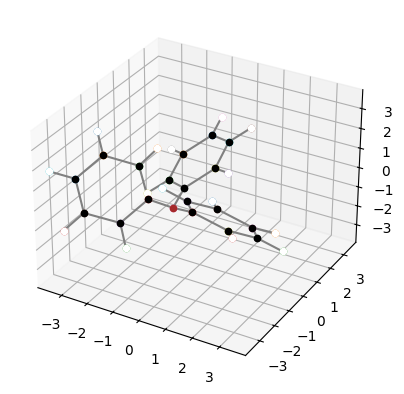

'C3'

In [4]:
atom_mapping('C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=CC=CC=C3', False, True)

The problem with rdkit is that to generate such confomer, one will use optimising functions. However, such functions will optimise the 3D confomer to achieve the lowest energy possible, which is *not always* a high symetry confomer. There is no rdkit function that maximises the symetry of the molecule.To compensate for this, PGdet package includes a function called "config_mol". We shall now take a closer look at its functionalities.

# 2.3 Config_mol, plot_molecule and molecule_angles

First of all, let's generate a confomer of a molecule and optimise it with rdkit. Then, we will create another confomer optimised with config_mol and compare them. To compare them, we will use plot_molecule, a matplotlib-based function that prints the molecule in 3D. We will also use other functions less important which calculate angles between substituants of the carbons. Run the following code. Once done, you can run it anoter time. You can see one of the main issues with rdkit: the atoms are not placed consistantly in space, their positions varrying between each run. It may not be that visible with toluene, but if you try with methane instead ( *smiles: 'C'* ), it will be obvious. Hopefully, such things does not happen with PGdet.

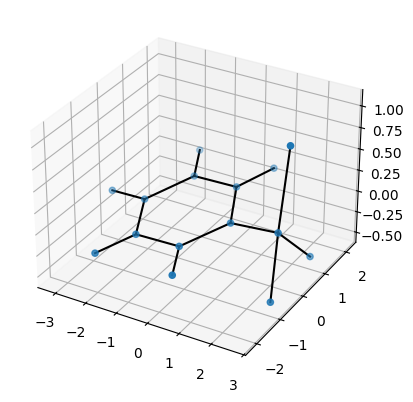

Point group:  C1


In [50]:
# let's look at toluene, which smiles is: C1=CC=CC=C1(C)
# We start with creating a rdkit object, add its hydrogens:
def example_function(smiles):
    mol = Chem.MolFromSmiles("C1=CC=CC=C1(C)")
    mol = Chem.AddHs(mol)
    # We also optimise the confomer using built-in rdkit functions:
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    # To plot the molecule, we need to get some more data about the molecule:
    # We find the position of each atom:
    conformer = mol.GetConformer()
    positions = conformer.GetPositions()
    x = [pos[0] for pos in positions]
    y = [pos[1] for pos in positions]
    z = [pos[2] for pos in positions]

    # Generates a 3D object
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    atom_pairs = []
    #Draw atoms
    ax.scatter(x, y, z)
    #We need to find and plot the bonds:
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        atom_pairs.append((start, end))
        ax.plot([x[start], x[end]], [y[start], y[end]], [z[start], z[end]], 'k-')
    
    # We can now plot the molecule...
    plt.show()

#... and use PointGroup to find its point group with the current data:
    pg = PointGroup(positions=positions, symbols=[atom.GetSymbol() for atom in mol.GetAtoms()])
    print('Point group: ', pg.get_point_group())

example_function('C1=CC=CC=C1(C)')

As we can see here, the code is compact but the result is decieving. The real point group of toluene is $Cs$ and the representation seems geometrically incorrect. If we measure the angles between carbon substituants, we will find that none of them is at $109.5°$. The other $sp^2$ carbons have quite accurate angles however. We can verify it that way using another function of PGdet:

In [52]:
print(molecule_angles(positions,atom_pairs))

[(1, 2, 0, 120.06639713962925), (5, 0, 1, 120.4312921467149), (0, 7, 1, 119.2527818864458), (1, 8, 0, 119.94096362347234), (2, 3, 1, 119.92025796939599), (1, 8, 2, 119.99240322439704), (2, 9, 1, 120.03961676671497), (3, 4, 2, 120.06640266852321), (2, 9, 3, 120.03961336108759), (3, 10, 2, 119.99240367225008), (4, 5, 3, 120.43128352669133), (3, 10, 4, 119.94095762956934), (4, 11, 3, 119.25277820742919), (5, 6, 4, 120.43547780182001), (5, 0, 4, 119.07321319221148), (4, 11, 5, 120.315918794122), (5, 0, 6, 120.43543640211018), (6, 12, 5, 110.89875444245016), (6, 13, 5, 110.89880238197316), (6, 14, 5, 109.99216852237217), (0, 7, 5, 120.31590648062499), (6, 13, 12, 107.22260103597978), (6, 14, 12, 108.87539243164888), (6, 14, 13, 108.87538473108827)]


Molecule_angles give a list of tuples as an output. The first three numbers of the tuple are the ids of the three atoms. The function will then measure the angle between the three substituants. As you can see, some carbon atoms of the molecule are $sp^2$ and therefore, we get angles close to $120°$. The $sp^3$ carbon atom has angles quite far from the $109.5°$ wanted. As you can see, the code on top works quite well but is not efficient enough. In order to determine the point group of a molecule, we need very precise and accurate angles. A slight imprecision and the point group instantly becomes $C_1$. Rdkit does well with small molecules. When it comes to larger ones, the small imprecisions adds together and makes almost impossible to find the accurate point group. Now, let's try the same thing with PGdet's functions. 

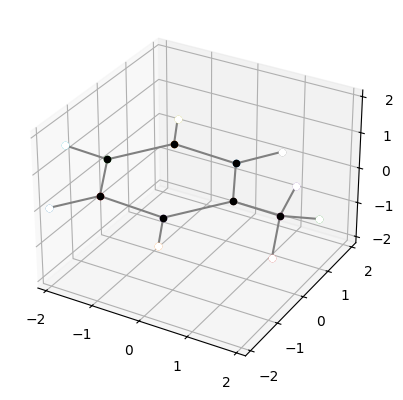

Molecule SMILES : C1=CC=CC=C1(C)
Molecule point group : Cs
Atoms list : ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
Coordinates : [[ 8.40155002e-02  1.20954994e+00 -2.51540903e-02]
 [-1.31238643e+00  1.28864265e+00 -2.28924404e-02]
 [-2.08023121e+00  1.20792070e-01 -9.00885613e-03]
 [-1.45285203e+00 -1.12811486e+00  7.73091682e-03]
 [-5.66930057e-02 -1.21138663e+00  5.52246424e-03]
 [ 7.20833356e-01 -4.22311563e-02 -2.64597398e-02]
 [ 1.71885009e+00 -9.99181158e-02 -1.26412158e-03]
 [ 6.22631306e-01  2.05210061e+00 -2.63278439e-02]
 [-1.76211836e+00  2.18179350e+00 -2.76610681e-02]
 [-3.07854015e+00  1.78851935e-01 -6.12268187e-03]
 [-2.00301962e+00 -1.96299346e+00  2.48585119e-02]
 [ 3.80699599e-01 -2.11041450e+00  2.64170225e-02]
 [ 2.11084635e+00  6.87631109e-01 -4.76769274e-01]
 [ 2.01319023e+00 -9.42544773e-01 -4.52201140e-01]
 [ 2.02941830e+00 -1.03971190e-01  9.49278333e-01]]
Bonds : [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (5, 0), (0, 7),

'Cs'

In [53]:
atom_mapping('C1=CC=CC=C1(C)', True, True)

As you can see, atom_mapping can take two more arguments, which are booleans. If the first is *True*, the function will print all informations gathered about the molecule. If the second argument is *True*, the function will directly print the molecule by calling plot_molecule. If you only want the point group, just put the smiles. Atom_mapping has these two arguments set as *False* as default. You can also notice that the point group found is $Cs$, which is correct. You can also try with cyclobutadiene (*smiles: C1=CC=C1*). Again, atom_mapping will find the correct point group ($D_{4h}$) while the other code will miss.


Plot_molecule is a function that needs:
1. the positions of each atom
2. a list of each atom
3. a list of tuples, each tuple being the tag of two atoms bounded together.
  
The function will then place the atoms in space, color them as function of their nature. It will also draw grey lines as bonds. To avoid the deformation of the molecule, it will also set the size of the graph so that it fits the size of the molecule. The last thing that it does is that it centers the molecule

There are some other useful features that are yet to be shown. For xample, you may have seen that plot_molecule associates colors with atoms. That way, a printed organic molecule is easier to visualise. The colors chosen correspond to our usual idea of them with carbons being black, oxygens red or nitrogens blue. If an atom is unusual, its color will be grey.

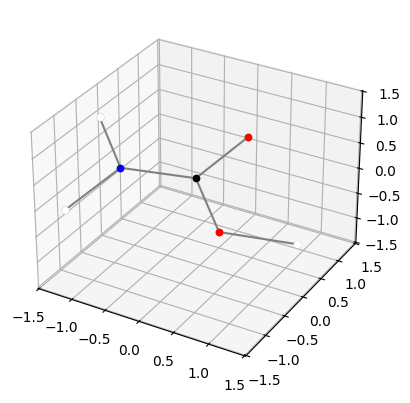

'Cs'

In [8]:
atom_mapping('NC(=O)O', False, True )

PGdet provides you a function called config_mol. This function is really important to the code, although its implication is only visible with atom_mapping. This function will make sure each carbon atoms has its substituants separated by the right angle. For example, $sp^3$ carbons must have $109.5°$ angles between its substituants. It modifies the angles for all substituants of all carbon atoms. That way, the molecule is more accurately represented and the point group is found accurately. However, after modifying these, we found that the point group was not correct. So we found out that the problem could come from the fact that dihedral angles were probably not corrects either. A dihedral angle is well represented by the following image :

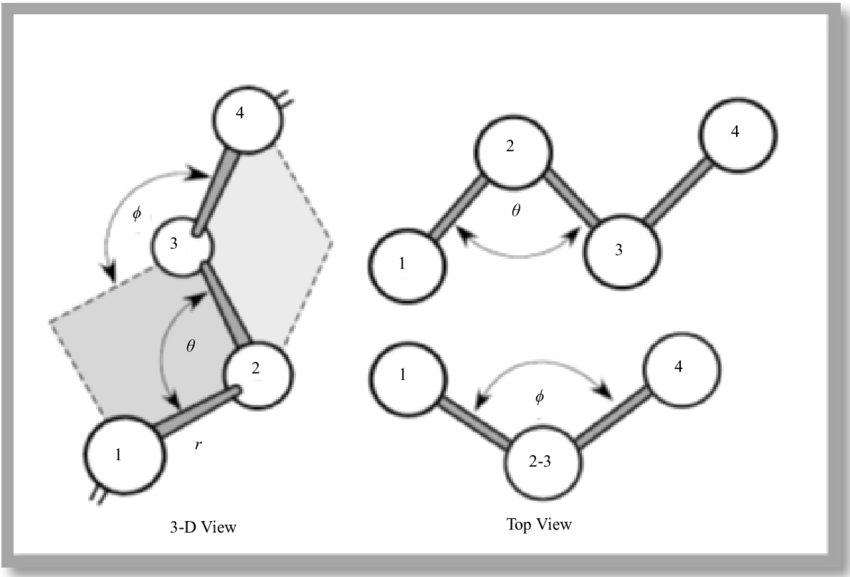

( *source: https://www.researchgate.net/figure/a-Se-chain-molecules-and-the-definition-of-the-dihedral-angle-The-dihedral-angle-is_fig1_276170064* )

A dihedral angle is calculated from four atom positions in space. Since PGdet only determines point group of organic molecules, all dihedral angles are set to equal $60°$. Obviously, it only modifies dihedral angles if one of the atoms is a carbon atom and as long as it is not part of a ring. 

# 2.4 Count_atoms, pg_check_smiles and molecule bonds

These are the last functions of PGdet's package. They are mainly done for calculations. Count_atoms simply counts the number of non-hydrogen atoms in the molecule so that if a user asks for a molecule exceeding the limit of 25 atoms within the molecule (without counting the hydrogens obviously). Pg_check_smiles ensures that "smiles" do not transgress any established rules ( *25 atoms limit, purely organic* ). Molecule_bonds creates a list of tuples. Each tuple is composed with two number, each one being the id of an atom of the molecule. The id starts from 0 and ends at $n-1$ with n, and corresponds to the position of the atom in the list of all atoms. The last function, moecule_bonds sets all bonds to have the same length ( *except if the atom is in a cycle* ) so that some innacuracies can be easily avoided.

# **3.To got further**

# 3.1 Limitations and issues with specific molecules

PGdet is a simple way to find point groups of purely organic molecules. But why are they specifically only purely organic ? Let's dive in the limitations of libraries and of PGdet itself.

1. Inorganic and organo-metallic molecules

If you try to use atom mapping on organo-metallic or inorganic molecules, the function will rise an error. Let's try with Ferrocene ( *Iron, bis(eta5-2,4-cyclopentadien-1-yl), smiles:[CH-]1C=CC=C1.[CH-]1C=CC=C1.[Fe+2]* ).

In [38]:
atom_mapping('[CH-]1C=CC=C1.[CH-]1C=CC=C1.[Fe+2]', False, True)

TypeError: Error: the smiles corresponds to an organometallic complex, which is not suited by the program.

The functions are not suited to handle complexes or charged molecules. Here, you can see that the complex is rejected. The reason why is simple. If for purely organic molecules, fixing all angles and dihedral angles was doable, the same thing couldn't be said for metals and lanthanides. The reason why is because they have d orbitals as outer orbital. This makes them much harder to predict when it comes to shapes of the molecule. Then, to patch this, we have to change the code so that it is able to find crystals point groups. It should also be able to determine the shape of an organo-metallic molecule based on the nature of the metal and its ligands. Same problems happend when it comes to purely inorganic compounds. Let's have a look at $SF_6$, an octahedral molecule. ( *smiles: S(F)(F)(F)(F)(F)F* ).

In [43]:
atom_mapping('S(F)(F)(F)(F)(F)F')

TypeError: Error: The smiles input corresponds to an inorganic molecule. No molecule could be printed. The molecule should be purely organic or be an exception: ['O', 'N', 'NN', 'O=O', 'N=N', 'N#N', 'OO']

Another error is raised. This is because the atoms are not placed in space correctly. The moecule is obviously not octahedral. You can try yourself with the smiles and the code upwards, you will see that the result is somewhat chaotic. Some inorganic are still working though, it is the case of the sulfur crown $S_8$ ( *smiles: S1SSSSSSS1* ), which should yield a point group of $D_{4d}$. However, rather than selecting one by one the inorganic molecules that were working, we decided to choose some very common such as water, ammonia and hydrochloric acid and unallow the other ones.

Organo-metallic and purely inorganic molecules does not have the same angles as organic molecule. Changing the molecule so that the comformation manually changed is accurate becomes a nightmare to code. 

2. Limitations of the size of the molecules and rdkit conformer inaccuracies

The size of the molecule is limited. If your molecule is composed with more than 25 non-hydrogen atoms, the code will raise an error and tell you that the molecule is too large. Let's try it.

In [5]:
atom_mapping('CCCCCCCCCCCCCCCCCCCCCCCCCC')

TypeError: Error: The smiles input is too long. Maximum non hydrogen atoms allowed : 25

The code is helped by another function yet not mentionned. Count_atoms is a simple function that just counts the number of atoms in the molecule. The vallue is then used by pg_check_smiles to make sure that the function does not run if there are too much atoms. That way, even if the smiles is very long, ( *len(smiles) >> 25* ) the code will still run.

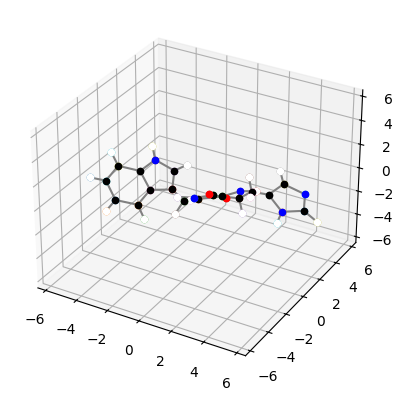

'C1'

In [8]:
atom_mapping('N3[C@@](CC(=CN2)C1=C2C=CC=C1)C(=O)N[C@@]([H])(CC1=CN=C-N1)C3(=O)', False, True)

This size of molécule is a limit. If the molecule is larger, PGdet will start to struggle finding the point group of it. Even at this size, some imprecisions can be seen. We will see what it is all about. Here, we can see that we do not see clearly the central part of the molecule because jupyter notebook does not allow movement of the graph. We invite you to try using PGdet with an interface able to properly use matplotlib.

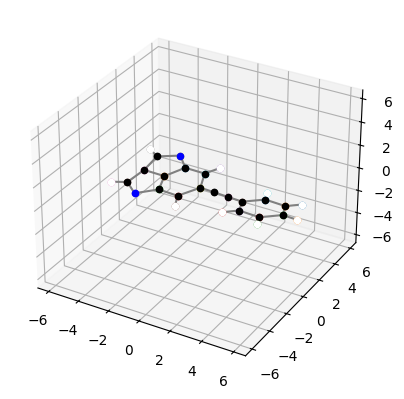

'C2'

In [10]:
atom_mapping('C1=CC=CC=C1C#CC2=CC4=C3C(=C2)N=CC3=C[N]4', False, True)

It appears that this molecule is $C_2$ according to atom_mapping. This is not accurate. There is a higher symetry confomer of this molecule that is $C_{2v}$. The problem here can be seen from a dfferent angle:

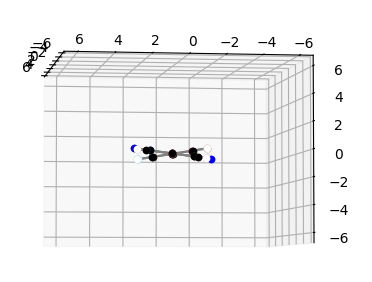

By taking a look at the molecule from another angle, the problem is obvious. With a triple bond between the two carbons, the molecule should be perfectly flat. However, since config_mol does not modify the angles more than dihedral angles, it does not correct the drift between the two cycles. Config_mol does not modify angles for chais of atoms longer than 4. Therefore, the imprecisions of rdkit are the only responsible for this mistake. 

Changing these angles is fairly hard. What happened here is even more obvious when we look at 6 atoms alkanes.

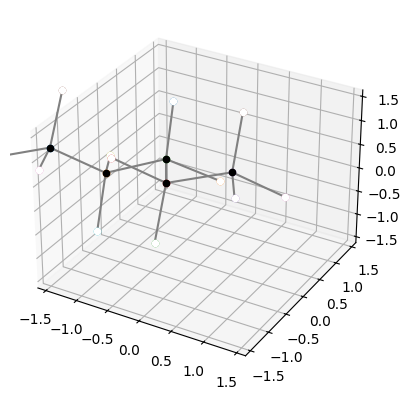

'C1'

In [13]:
atom_mapping('CCCCC', False, True)

As you can see here, when it comes to long carbon chains, the representation is not correct. This is because, PGdet uses rdkit first to get the confomer and then modifies it. However, it changes the angles not the overall confomer. In other words, the angles are corrected, not the general shape of the molecule. We get moecules like this one that are supposed to be perfectly linear but are not.

it becomes more obvious from another point of view:

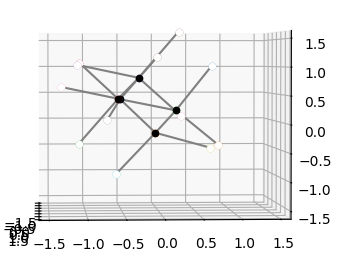

Two things can be denoted from here. First, the carbons are not aligned and do not form a straight chain. Otherwise, we would see two black dots. The other observation we can make is the following. Some hydrogens, that should align perfectly, are not in superposition. This is caused because of the perspective imposed with matplotlib. This is a factor that you should not forget. Sometimes the molecule seems wrongly represented. The reason is some times the perspective. Here is why we recommend to use the package with a medium that allows to move the graphic. We recommend to use spyder or conda because these are the ones we tested the code with.

3. Inaccuracies of heteroatoms

Some heteroatoms can have hydrogens bonded to them. The most common ones in organic molecules are oxygens and nitrogens. The problem with these hydrogens is that they are almost never placed well. Benzaldehyde for example ( *smiles: C1=CC=CC=C1(C=O)'* ) sees its hydrogen wrongly placed. It results in a $C_1$ output of the function. This result is wrong because benzaldehyde should be completely flat. PGdet struggles when it comes to bonding organic functions or organic groups together. Benzaldehyde could be cut into two pieces, a benzene ring and a "formaldehyde". 

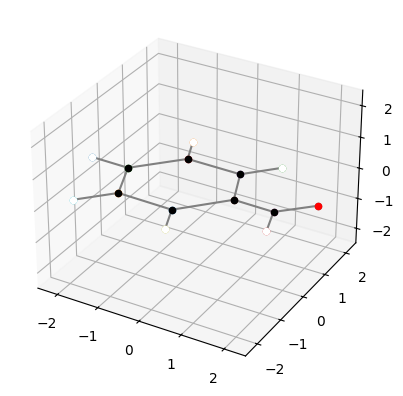

'C1'

In [16]:
atom_mapping('c1ccccc1(C=O)', False, True)

This result is wrong because benzaldehyde should be completely flat. PGdet struggles when it comes to bonding organic functions or organic groups together.

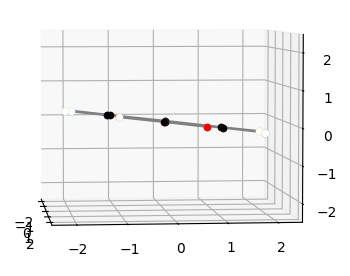

The difference in angle is almost not visible. We should not forget that there is also a deformation of the molecule due to perspective. The library point group requires a very high precision in the position of the atoms in space. Let's try to decompose the molecule. Benzaldehyde could be cut into two pieces, a benzene ring and a formaldehyde. 

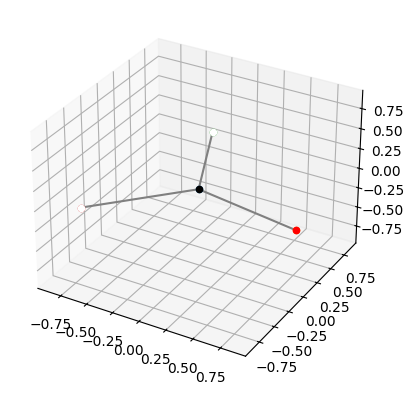

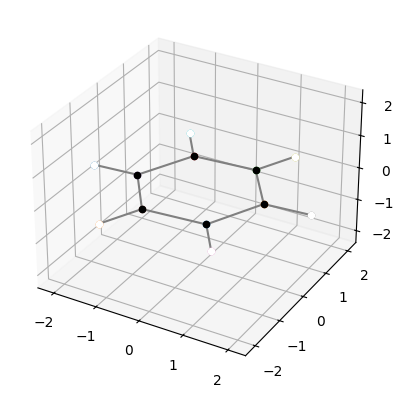

['C2v', 'D6h']

In [17]:
atom_mapping(['C=O', 'c1ccccc1'], False, True)

Both alone are true. The results are corresponding to what was said earlier. The same result can be observed with caffeine, supposed $C_s$ but appears $C_1$ although the graph looks very much like $C_s$ ( *smiles: 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'* ). The fact that for such little innacuracies, the point group is false is quite annoying. The function provided by the point group library allows to modify the precision of the function that determine the point group. However, changing slightly the tolerance and all molecules become $C_{infinity, v}$. 

# **4. Conclusion**

As we have seen, PGdet features an ensemble of functions. They all either provide informations or either modify the confomer so that the point group can be determined. To get the most accurate and highest symetry confomer, PGdet provides functions that modifies and optimise the confomer, using rdkit. Atom_mapping, which is the main function of PGdet, also allows you to get lots of useful informations such as the the angles of the bonds. That way, coupling this with the plotting capabilities of PGdet, you can see the confomer produced. If the point group given seems strange, you can still look at the molecule to convince yourself about the answer. 

PGdet has some ways of improvments that may come later in new updates ! The ways the code can be improved were already said earlier. By fixing the way the initial confomer is placed, the code could be improved a lot. An other way to get better results with exotic molecules such as purely inorganic ones or organo-metallic complexes would be to create functions that modify the angles between ligands of metals ( *for organometallic for example* ). Such thing is quite hard to do but may arrive soon. Another way to improve the quality of the output would be to also print the symetry operations associated with the determined point group. 
Thank you for giving interrest in our project in the first place, we hope you will find some interessting uses of our package. If you get strange results, feel free to ask the team by rising an issue on our Github, we will be more than happy to help.

Here is a **bonus**: now that we have been through all the functionnalities of the package, you can try it here simply by running the following cell. You can play with it if you want. Try the following smiles, the results will probably impress you ( *don't forget that you can use multiple smiles while running the function* ): 

1. Hexane: 'CCCCCC'
2. Cubane: 'C12C3C4C1C5C2C3C45'
3. Ethanol: 'CCO'
4. Benzene: 'c1ccccc1'
5. Ammonia: 'N'
6. Iodomethane: 'CI'
7. The total list that can be put rather than each smiles: ['CCCCCC','C12C3C4C1C5C2C3C45','CCO','c1ccccc1','N','CI']

In [ ]:
atom_mapping_interface()